In [1]:
project_home = %env PROJECT_HOME
%cd $project_home

F:\ai_voucher\MeritOrderPrediction


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.init import xavier_uniform_

In [3]:
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

## Read Data

In [4]:
df_load = pd.read_csv("./data/load_data.csv",
                   header=[0],
                   index_col=0,
                   parse_dates=True
                  )

df_load.index = pd.to_datetime(df_load.index,
                            utc=True
                           ).tz_convert(tz="Europe/Berlin")



In [5]:
df_load = df_load["2022-01":"2022-12"]

In [6]:
df_values = df_load[["load"]].values.astype('float32')

# train-test split for dataset

In [7]:
train_size = int(len(df_load["load"]["2022-01":"2022-08"]))
test_size = len(df_load["load"]) - train_size
train, test = df_values[:train_size], df_values[train_size:]

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [9]:
lookback = 96 # Size of window for prediction
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Messaccount\AppData\Local\Temp\ipykernel_19104\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.tensor(X), torch.tensor(y)


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([23228, 96, 1]) torch.Size([23228, 96, 1])
torch.Size([11524, 96, 1]) torch.Size([11524, 96, 1])


# Define model

In [11]:
class LoadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=96, num_layers=1, batch_first=True)
        self.linear = nn.Linear(96, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
model = LoadModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=12)

# Train and predict

In [13]:
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print(epoch)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

0
Epoch 0: train RMSE 56691.5039, test RMSE 54870.2031
10
Epoch 10: train RMSE 56218.0703, test RMSE 54395.8789
20
Epoch 20: train RMSE 55744.7461, test RMSE 53921.6445
30
Epoch 30: train RMSE 55271.5742, test RMSE 53447.5508
40
Epoch 40: train RMSE 54798.5430, test RMSE 52973.5898
50
Epoch 50: train RMSE 54325.6680, test RMSE 52499.7734
60
Epoch 60: train RMSE 53852.9375, test RMSE 52026.0898
70
Epoch 70: train RMSE 53380.3242, test RMSE 51552.5078
80
Epoch 80: train RMSE 52907.9219, test RMSE 51079.1133
90
Epoch 90: train RMSE 52435.6758, test RMSE 50605.8789


In [14]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_values) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_values) * np.nan
    test_plot[train_size+lookback:len(df_values)] = model(X_test)[:, -1, :]

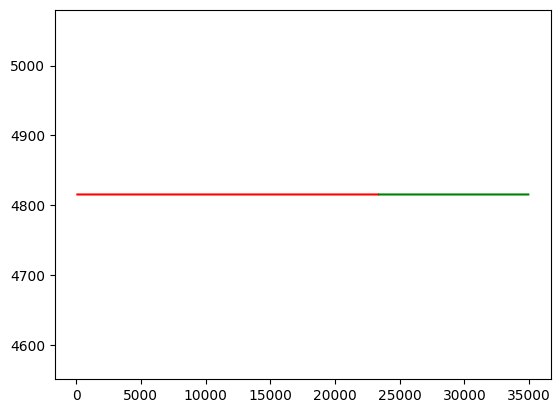

In [16]:
# plot
#plt.plot(df_values)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()